In [138]:
import pandas as pd
import numpy as np
import hvplot.pandas  # noqa
import matplotlib.pyplot as plt
import logging
import copy
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

import lab_tools
import pickle
logging.basicConfig(level=logging.INFO)
import math
from scipy.constants import mu_0 as mu_0
from uncertainties import ufloat
import uncertainties
from uncertainties import unumpy
from matplotlib import pyplot
import os

In [127]:
def uplot(x_ufloats, y_ufloats):
    plt.errorbar( unumpy.nominal_values(x_ufloats), unumpy.nominal_values(y_ufloats),
      xerr=unumpy.std_devs(x_ufloats), yerr= unumpy.std_devs(y_ufloats), fmt='.',ecolor='green',barsabove=True)

In [51]:
path = r'C:\Users\noach\OneDrive\Documents\GitHub\Lab-B\magnetisem\extension2\first'
path2 = r'C:\Users\noach\OneDrive\Documents\GitHub\Lab-B\magnetisem\extension2\second'
path3 = r'C:\Users\noach\OneDrive\Documents\GitHub\Lab-B\magnetisem\extension2\3'
path4 = r'C:\Users\noach\OneDrive\Documents\GitHub\Lab-B\magnetisem\extension2\high_freq'
path5 = r'C:\Users\noach\OneDrive\Documents\GitHub\Lab-B\magnetisem\extension2\all'
path6 = r'C:\Users\noach\OneDrive\Documents\GitHub\Lab-B\magnetisem\extension2\high_freq_week2'

# d = lab_tools.read_to_dict(path)
d1 = lab_tools.read_to_dict(path)
d2 = lab_tools.read_to_dict(path2)
d3 = lab_tools.read_to_dict(path3)
d4 = lab_tools.read_to_dict(path4)
d6 = lab_tools.read_to_dict(path6)


dict_names1 = [d1,d2,d3]
dict_names2 = [d4]
mod_data = {}

for name in dict_names1:
    for key in name.keys():
        mod_data[key] = name[key]
        for index in range(len(mod_data[key]['x'])):
           mod_data[key]['x'][index] = mod_data[key]['x'][index]/10
        for index in range(len(mod_data[key]['y'])):
            mod_data[key]['y'][index] = mod_data[key]['y'][index]/10

for name in dict_names2:
    for key in name.keys():
        mod_data[key] = name[key]

# for key in d6.keys():
#     mod_data[key] = d6[key]
#     ney_y = d6[key]['x']
#     ney_x = d6[key]['y']
#     mod_data[key]['y'] = ney_y
#     mod_data[key]['x'] = ney_x

# d = lab_tools.read_to_dict(path5)

In [103]:
impedance = []
imp_freq = []
R = ufloat(19.2,0.15)

for x in mod_data.keys():
    amp1 = abs((max(mod_data[x]['y'])-min(mod_data[x]['y'])))
    amp2 = abs((max(mod_data[x]['x'])-min(mod_data[x]['x'])))
    imp_freq.append(int(x))
    impedance.append(R*(amp1/amp2))

# for x in d6.keys():
#     amp1 = abs((max(d6[x]['y'])-min(d6[x]['y'])))
#     amp2 = abs((max(d6[x]['x'])-min(d6[x]['x'])))
#     imp_freq.append(int(x))
#     impedance.append(R*(amp1/amp2))

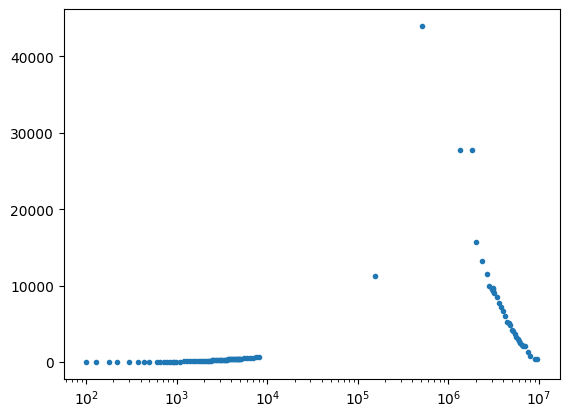

In [53]:
plt.semilogx(imp_freq, impedance, '.')

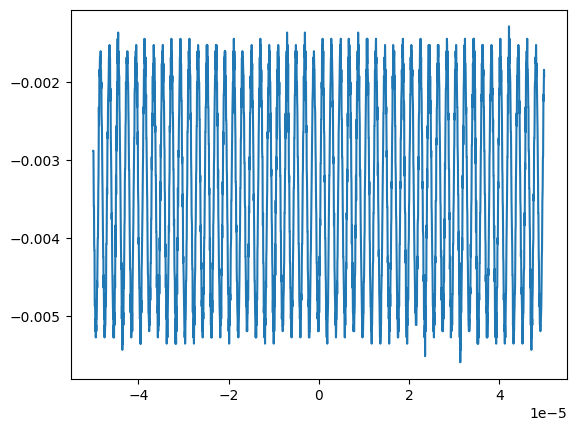

In [54]:
plt.plot(mod_data['507517']['t'],mod_data['507517']['x'])

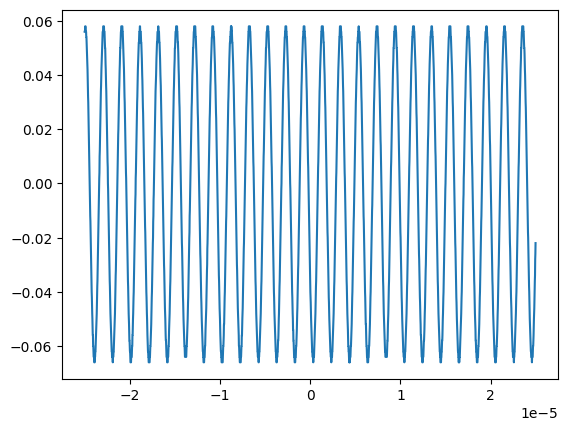

In [55]:
plt.plot(d6['495000']['t'],d6['495000']['x'])

In [56]:
logging.basicConfig(level=logging.WARNING)

phases = []
frequencies = []
amplitudes = []
faild_fits = {}

def find_phase(w,a1,w1,p1,c1,a2,w2,p2,c2):
    f = 2 * np.pi / w
    return f * np.abs(p1 - p2)

def find_z(w,a1,w1,p1,c1,a2,w2,p2,c2):
    return a2 / a1

def find_w(w,a1,w1,p1,c1,a2,w2,p2,c2):
    return w1


funcs = {'phase': find_phase, 'z': find_z,'freq_in':find_w}
limits = {'z': [0, 10000]}


for freq, df in copy.deepcopy(mod_data).items():
    float_freq = float(freq)
    logging.info(f"frequency is {freq}")
    result = lab_tools.extract_data_from_fit(funcs, df, float_freq, display=False)

    if result:
        frequencies.append(result['freq_in'])
        phases.append(result['phase'])
        amplitudes.append(result['z'])

    else:
        faild_fits[freq] = df
        del mod_data[freq]


fit failed for frequency 100.0


fit failed for frequency 130.0


fit failed for frequency 180.0


fit failed for frequency 1836600.0


fit failed for frequency 7016600.0


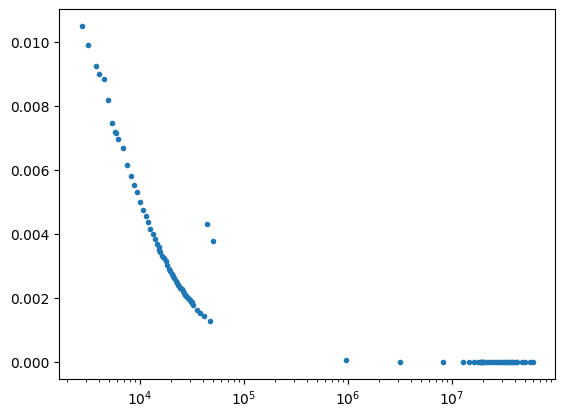

In [57]:
plt.semilogx(frequencies, phases, '.')


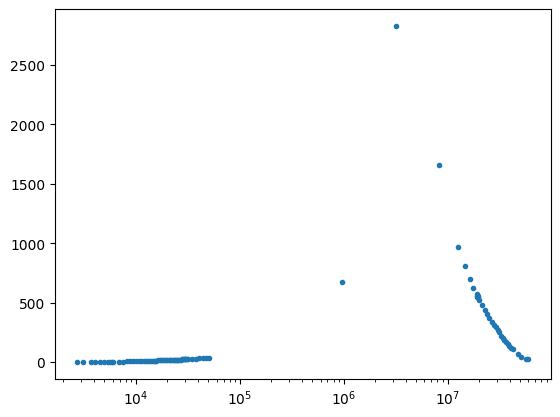

In [58]:
plt.semilogx(frequencies, amplitudes, '.')

In [146]:
L = ufloat(0.0125,0.00025)
R = ufloat(19.2,0.1)
r = ufloat(0.02,0.003)
A = 2*math.pi*(r**2)
l = 2*r
N_square = (L*l)/(A*mu_0)

R_effective = []
L_effective = []
L = ufloat(0.0125,0.0008)
for index in range(len(amplitudes)):
    R_effective.append(amplitudes[index]*math.cos(phases[index]) - R)
    L_effective.append((amplitudes[index]*math.sin(phases[index]))/frequencies[index])

Real_mu = []
Im_mu = []

for index in range(len(R_effective)):
    Real_mu.append(l*R_effective[index]/(mu_0*frequencies[index]*N_square*A))
    Im_mu.append(l*L_effective[index]/(mu_0*frequencies[index]*N_square*A))


In [147]:
permeability = []
for index in range(len(Im_mu)):
    permeability.append(((Im_mu[index]**2 + Real_mu[index]**2)**0.5)/mu_0)

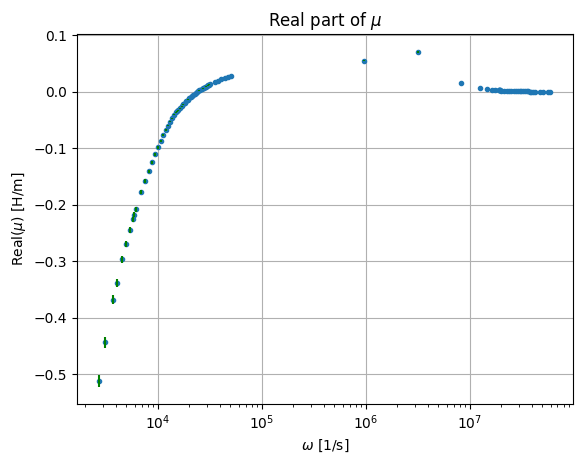

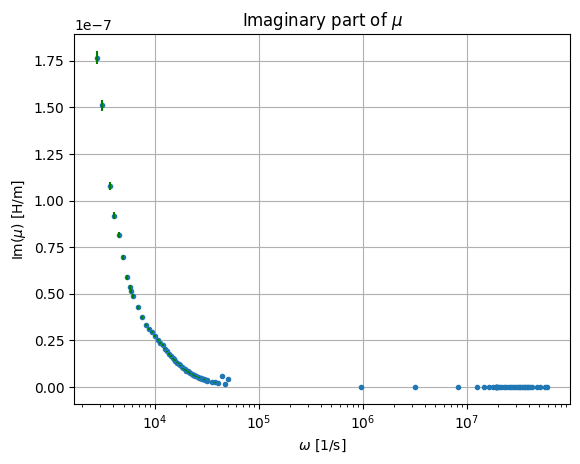

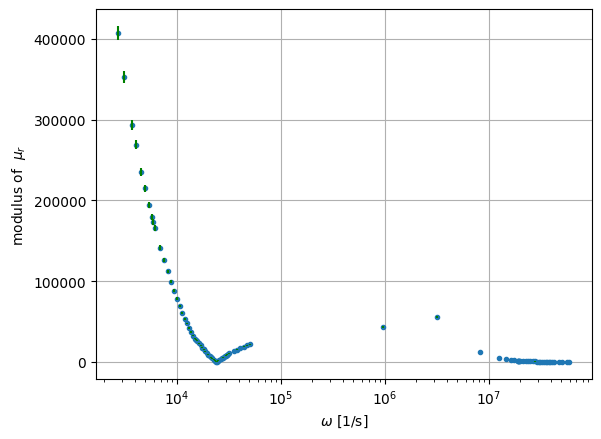

In [168]:

fig1 = plt.figure()
uplot(frequencies, Real_mu)
pyplot.xlabel('$\omega$'+' [1/s]')
pyplot.ylabel('Real($\mu$)'+' [H/m]')
pyplot.title('Real part of $\mu$')
pyplot.xscale('log')
plt.grid()

fig2 = plt.figure()
uplot(frequencies, Im_mu)
pyplot.xlabel('$\omega$'+' [1/s]')
pyplot.ylabel('Im($\mu$)'+' [H/m]')
pyplot.xscale('log')
pyplot.title('Imaginary part of $\mu$')
plt.grid()

fig3 = plt.figure()
pyplot.xlabel('$\omega$'+' [1/s]')
pyplot.ylabel('modulus' + ' of ' + ' $\mu_{r}$')
uplot(frequencies, permeability)
pyplot.xscale('log')
plt.grid()


In [164]:
def load_pickle(name):
    with open(os.path.join('pickles',f'{name}.pickle'), 'rb') as handle:
        return pickle.load(handle)

def save_pickle(name, pick):
    with open(os.path.join('pickles',f'{name}.pickle'), 'wb') as handle:
        return pickle.dump(pick,handle)

In [165]:
plt.savefig